# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten 
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Data Loading

In [18]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

# !wget "https://sussex.box.com/shared/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz" -O training_images_full.npz
# !wget "https://sussex.box.com/shared/static/axweldiirenlc4a6xn06l6heiuawodpa.npz" -O training_images_subset.npz

# # The test images (without points)
# !wget "https://sussex.box.com/shared/static/2ss21w2g8nd8fshhtu9r2ww2mm04xh9f.npz" -O test_images.npz

# # # The example images are here
# # !wget "https://sussex.box.com/shared/static/65pyy3pjnkl5yda7ra4rvhcd89l6i7fq.npzz" -O examples.npz


# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [19]:
# def confirm_checksum(filename, true_checksum):
#   import subprocess
#   checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
#   assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

# confirm_checksum('training_images_full.npz', '69927c788396d4b8c05d33d1650b2aa66076c0f0')
# confirm_checksum('training_images_subset.npz', '5e2690718c7b1a0d14db54f844e6e22453f5eb71')
# confirm_checksum('test_images.npz', 'aed32f84664e906624c8af13b5462cbded13d539')
# confirm_checksum('examples.npz', '2ea08d7b6d76b56de97325fe51daad72afaa3d73')

# Load the data

In [20]:
# Load the data using np.load
full_data = np.load('/content/drive/MyDrive/face alignment data/training_images_full.npz', allow_pickle=True)

# Extract the images
full_images = full_data['images']
# and the data points
full_landmarks = full_data['points']

print(full_images.shape, full_landmarks.shape)

# Load the data that only has a subset of annotations using np.load
sub_data = np.load('/content/drive/MyDrive/face alignment data/training_images_subset.npz', allow_pickle=True)

# Extract the images
sub_images = sub_data['images']
# and the data points
sub_landmarks = sub_data['points']

print(sub_images.shape, sub_landmarks.shape)

test_data = np.load('/content/drive/MyDrive/face alignment data/test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('/content/drive/MyDrive/face alignment data/examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(1425, 256, 256, 3) (1425, 44, 2)
(1386, 256, 256, 3) (1386, 5, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

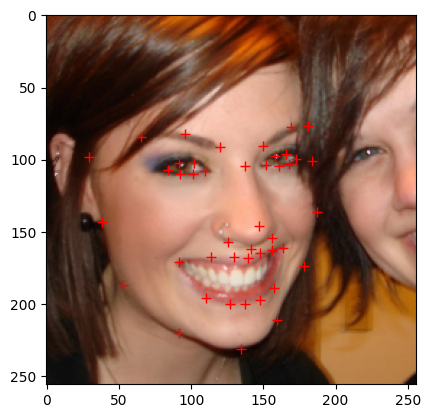

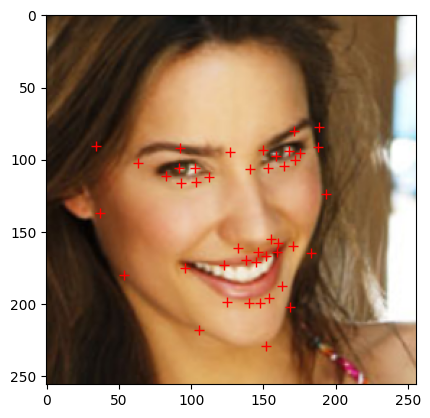

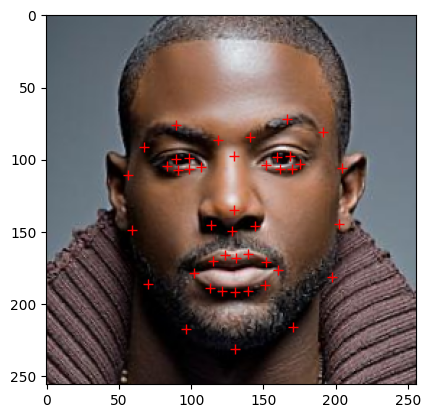

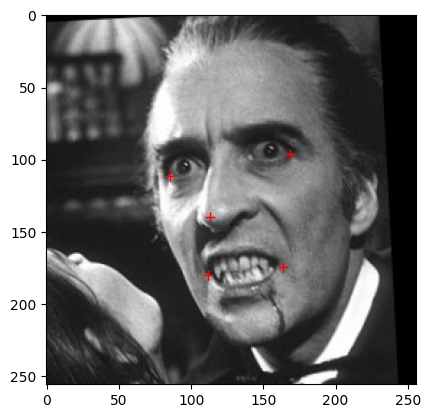

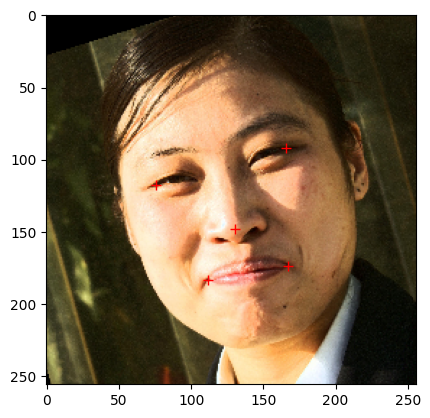

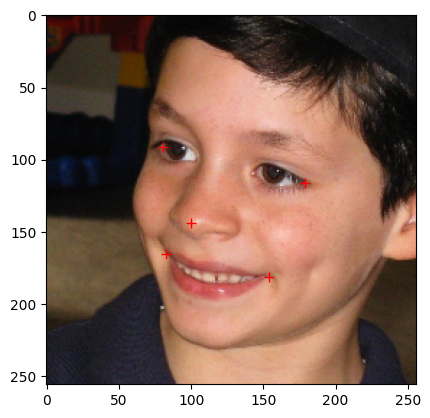

In [21]:
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r', ms=7)
  plt.show()

for i in range(3):
  idx = np.random.randint(0, full_images.shape[0])
  visualise_pts(full_images[idx, ...], full_landmarks[idx, ...])

for i in range(3):
  idx = np.random.randint(0, full_images.shape[0])
  visualise_pts(sub_images[idx, ...], sub_landmarks[idx, ...])

##extract subset from full set

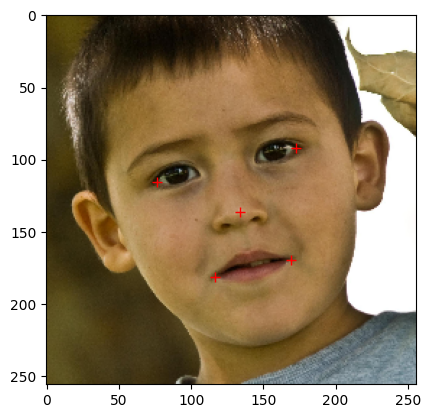

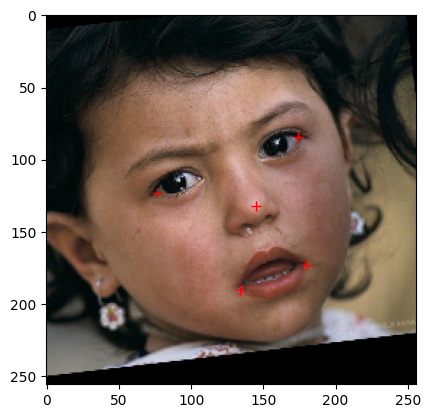

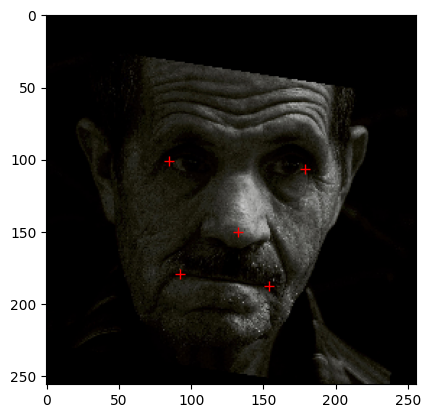

In [22]:
def extract_subset_of_points(pts):
  indices = (20, 29, 16, 32, 38)
  if len(pts.shape) == 3:
    return pts[:, indices, :]
  elif len(pts.shape) == 2:
    return pts[indices, :]


for i in range(3):
  idx = np.random.randint(0, full_images.shape[0])
  visualise_pts(full_images[idx, ...], extract_subset_of_points(full_landmarks[idx, ...]))

#Data preprocessing

In [23]:
# Define the function to resize the images
def resize_images(images, target_size):
    resized_images = np.zeros((images.shape[0], *target_size, images.shape[3]))
    for i in range(images.shape[0]):
        resized_images[i] = cv2.resize(images[i], target_size)
    return resized_images

In [24]:
# Resize the images to 128x128
target_size = (128,128)
full_images_resized = resize_images(full_images, target_size)
sub_images_resized =resize_images(sub_images, target_size)
test_images_resized = resize_images(test_images, target_size)
ex_images_resized = resize_images(example_images, target_size)

# Normalize the images
full_images_norm = full_images_resized.astype('float32') / 255.0
sub_images_norm = sub_images_resized.astype('float32') / 255.0
test_images_norm = test_images_resized.astype('float32') / 255.0
ex_images_norm = ex_images_resized.astype('float32') / 255.0

# Scale the landmarks to match the resized images
full_landmarks_rescaled = full_landmarks / 256.0 * 128.0
sub_landmarks_rescaled = sub_landmarks / 256.0 * 128.0


##Split the full and subset data sets

In [25]:
# Split the full data into training and validation sets
full_images_train, full_images_val, full_landmarks_train, full_landmarks_val = train_test_split(
    full_images_norm, full_landmarks_rescaled, test_size=0.2, random_state=42)

# Split the sub data into training and validation sets
sub_images_train, sub_images_val, sub_landmarks_train, sub_landmarks_val = train_test_split(
    sub_images_norm, sub_landmarks_rescaled, test_size=0.2,random_state=42)

##define the loss function

In [26]:
def euclidean_distance_loss(pred_pts, gt_pts):
  pred_pts = tf.reshape(pred_pts, (-1, 2))
  gt_pts = tf.reshape(gt_pts, (-1, 2))
  return tf.sqrt(tf.reduce_sum(tf.square(pred_pts - gt_pts), axis=-1))

#model trained on full data

In [27]:
# Define the model
model_fulltrained = Sequential()

# Input layer for the images
model_fulltrained.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model_fulltrained.add(MaxPooling2D(pool_size=(2, 2)))
model_fulltrained.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_fulltrained.add(MaxPooling2D(pool_size=(2, 2)))
model_fulltrained.add(Flatten())
model_fulltrained.add(Dense(128, activation='relu'))
model_fulltrained.add(Dense(44*2, activation='linear'))
model_fulltrained.add(Reshape((44, 2)))


In [28]:
# Compile the model
model_fulltrained.compile(optimizer='adam', loss=euclidean_distance_loss, metrics=['accuracy'])

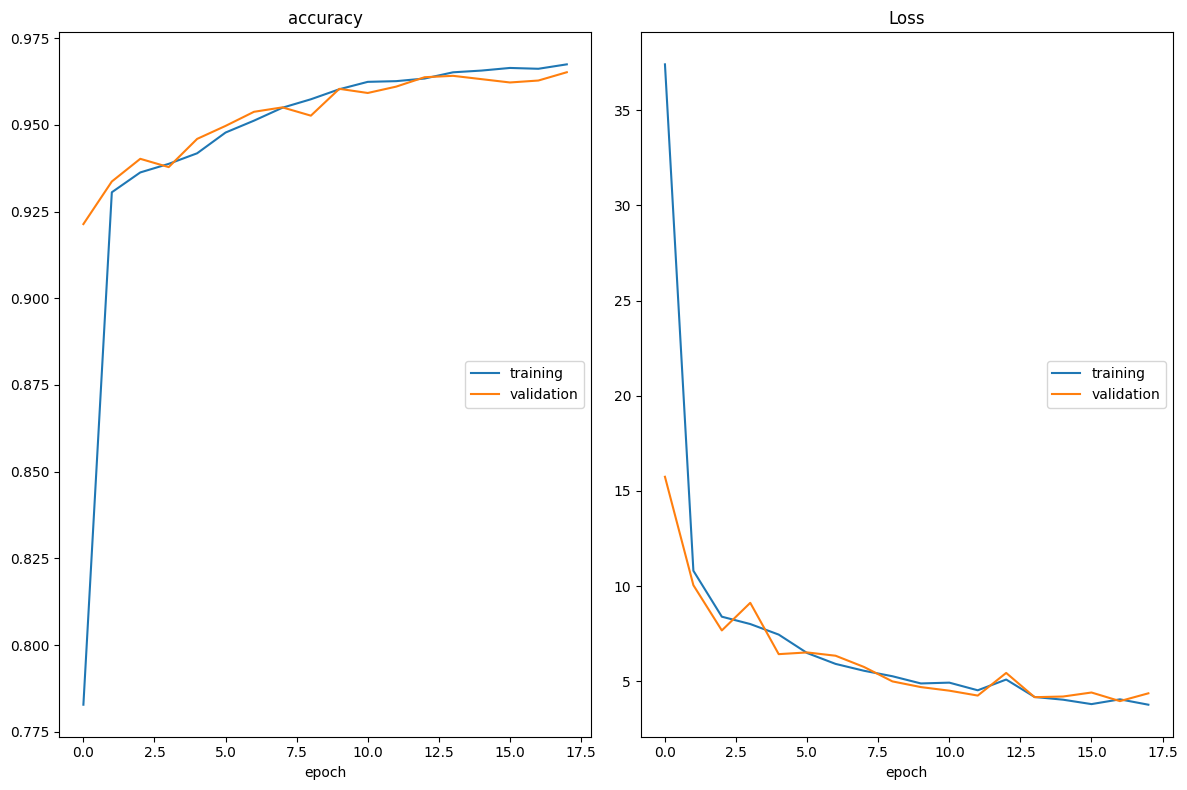

accuracy
	training         	 (min:    0.783, max:    0.967, cur:    0.967)
	validation       	 (min:    0.921, max:    0.965, cur:    0.965)
Loss
	training         	 (min:    3.765, max:   37.416, cur:    3.765)
	validation       	 (min:    3.954, max:   15.743, cur:    4.364)
36/36 [==============================] - 1s 39ms/step - loss: 3.7654 - accuracy: 0.9674 - val_loss: 4.3642 - val_accuracy: 0.9652


In [29]:
# Train the model 
history = model_fulltrained.fit(full_images_train,full_landmarks_train,
                    batch_size=32, epochs=18, validation_data=(full_images_val, full_landmarks_val),
                    callbacks=[EarlyStopping(patience=10),PlotLossesKeras(), ModelCheckpoint('model.h44', save_best_only=True)])

#model trained on subset data

In [30]:
model = Sequential()

# Input layer for the images
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5*2, activation='linear'))
model.add(Reshape((5, 2)))
# Compile the model
model.compile(optimizer='adam', loss=euclidean_distance_loss, metrics=['accuracy'])


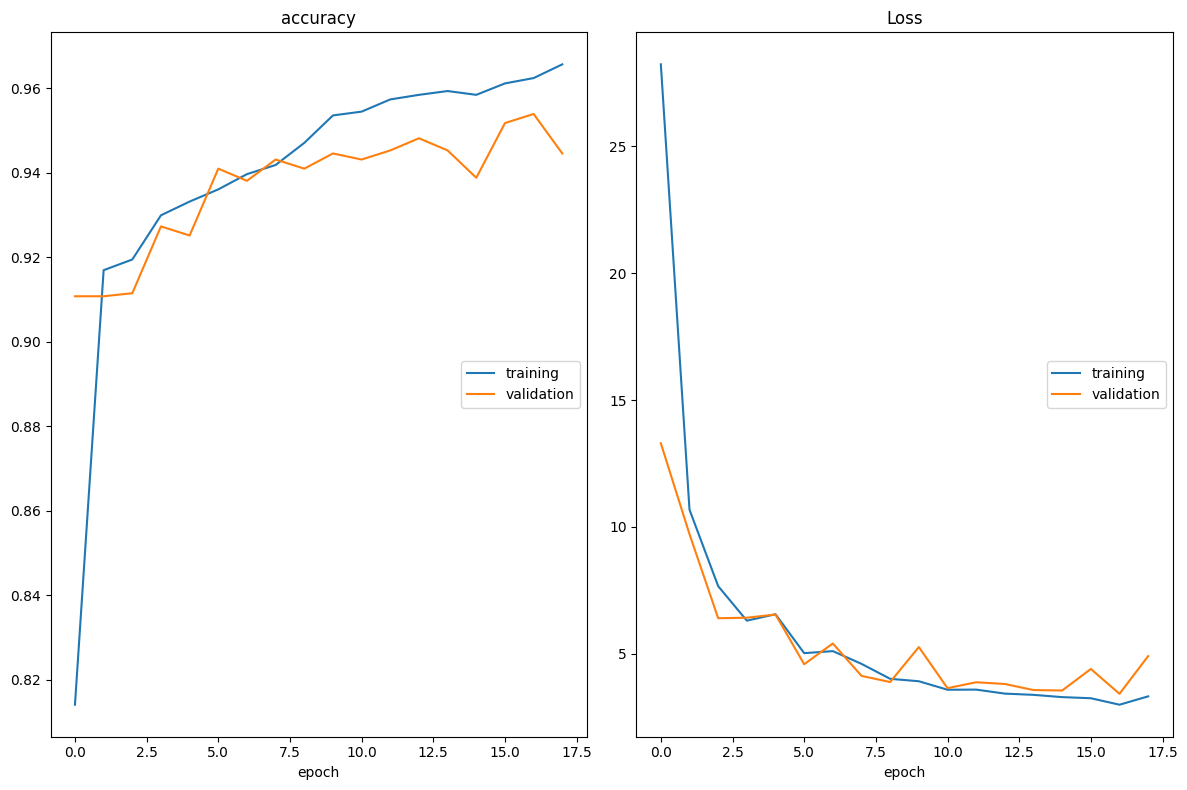

accuracy
	training         	 (min:    0.814, max:    0.966, cur:    0.966)
	validation       	 (min:    0.911, max:    0.954, cur:    0.945)
Loss
	training         	 (min:    2.998, max:   28.222, cur:    3.326)
	validation       	 (min:    3.427, max:   13.296, cur:    4.913)
35/35 [==============================] - 1s 43ms/step - loss: 3.3263 - accuracy: 0.9657 - val_loss: 4.9128 - val_accuracy: 0.9446


In [31]:
# Train the model 
history = model.fit(sub_images_train,sub_landmarks_train,
                    batch_size=32, epochs=18, validation_data=(sub_images_val, sub_landmarks_val),
                    callbacks=[EarlyStopping(patience=10),PlotLossesKeras(), ModelCheckpoint('model.h5', save_best_only=True)])


#pretrained the model trained on full data with subset data

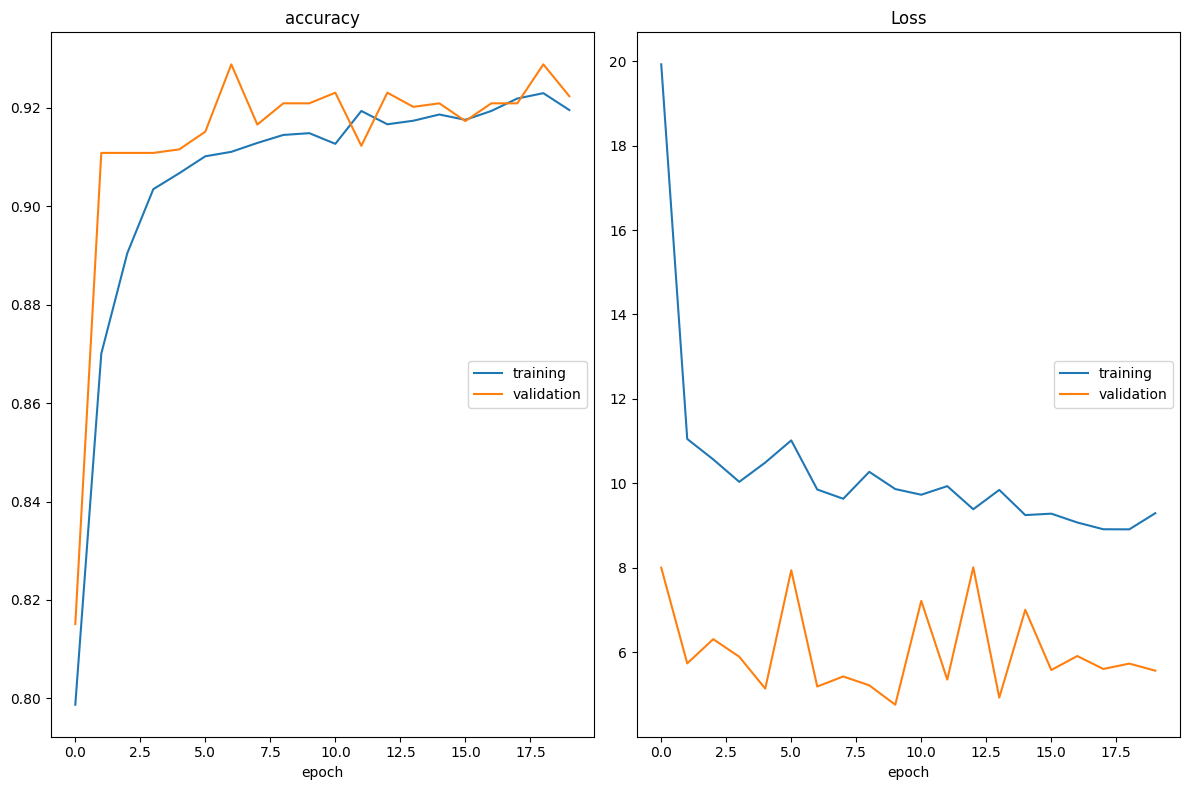

accuracy
	training         	 (min:    0.799, max:    0.923, cur:    0.919)
	validation       	 (min:    0.815, max:    0.929, cur:    0.922)
Loss
	training         	 (min:    8.914, max:   19.922, cur:    9.296)
	validation       	 (min:    4.762, max:    8.015, cur:    5.568)
35/35 [==============================] - 1s 36ms/step - loss: 9.2961 - accuracy: 0.9195 - val_loss: 5.5679 - val_accuracy: 0.9223


In [32]:
# Load the full trained model
full_model = load_model('model.h44',custom_objects={'euclidean_distance_loss': euclidean_distance_loss})

# Remove the last few layers of the model
x = full_model.layers[-4].output

# Add new trainable layers for the 5 landmarks dataset
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(5*2, activation='linear')(x)
x = Reshape((5, 2))(x)

# Create a new model
model = Model(inputs=full_model.input, outputs=x)

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in full_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.001), loss=euclidean_distance_loss,metrics=['accuracy'])

# Train the model with your subset data
history = model.fit(sub_images_train,sub_landmarks_train,
                    batch_size=32, epochs=30, validation_data=(sub_images_val, sub_landmarks_val),
                    callbacks=[EarlyStopping(patience=10),PlotLossesKeras(), ModelCheckpoint('model.h5v2', save_best_only=True)])


#pretrained model trained on subset data


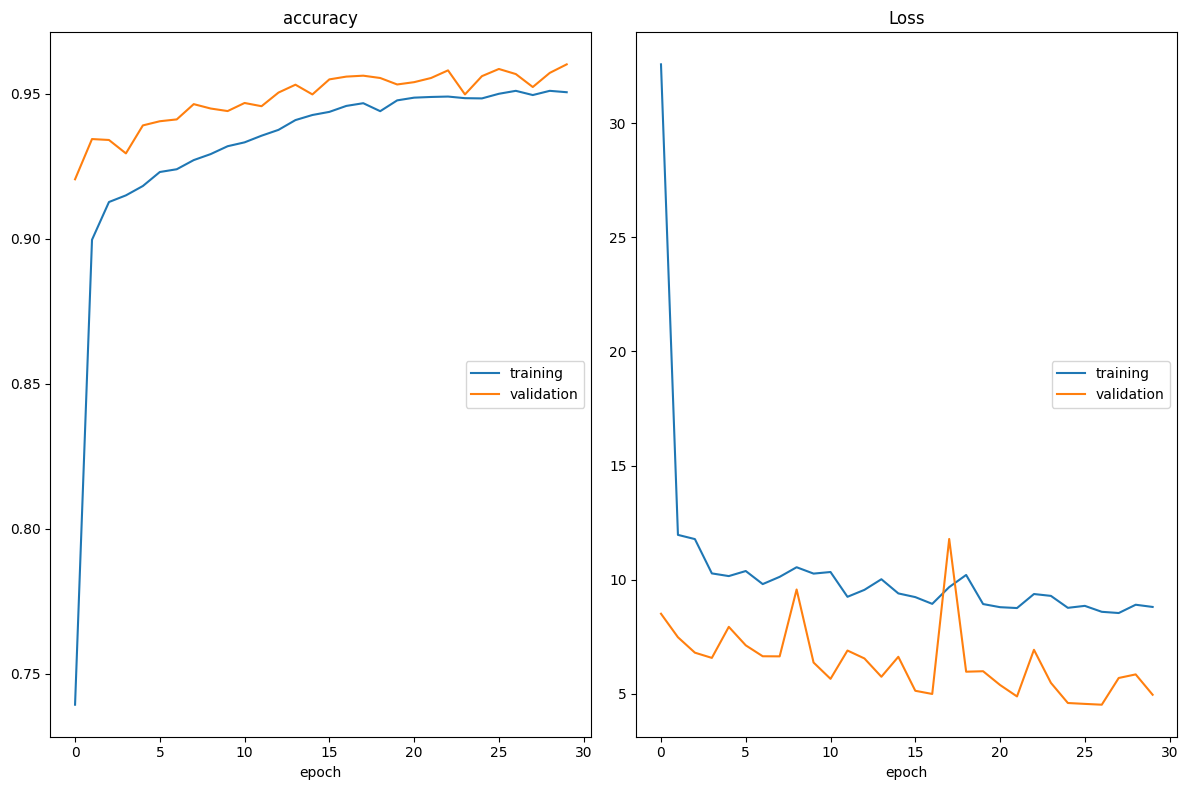

accuracy
	training         	 (min:    0.739, max:    0.951, cur:    0.951)
	validation       	 (min:    0.920, max:    0.960, cur:    0.960)
Loss
	training         	 (min:    8.543, max:   32.574, cur:    8.809)
	validation       	 (min:    4.527, max:   11.786, cur:    4.963)
36/36 [==============================] - 1s 34ms/step - loss: 8.8089 - accuracy: 0.9505 - val_loss: 4.9626 - val_accuracy: 0.9601


In [33]:

# Load the full trained model
sub_model = load_model('model.h5',custom_objects={'euclidean_distance_loss': euclidean_distance_loss})

# Remove the last few layers of the model
x = sub_model.layers[-4].output

# Add new trainable layers for the 5 landmarks dataset
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(44*2, activation='linear')(x)
x = Reshape((44, 2))(x)

# Create a new model
final_model = Model(inputs=sub_model.input, outputs=x)

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in sub_model.layers:
    layer.trainable = False

final_model.compile(optimizer=Adam(lr=0.001), loss=euclidean_distance_loss,metrics=['accuracy'])

# Train the model with your subset data
history = final_model.fit(full_images_train,full_landmarks_train,
                    batch_size=32, epochs=30, validation_data=(full_images_val, full_landmarks_val),
                    callbacks=[EarlyStopping(patience=10),PlotLossesKeras(), ModelCheckpoint('model.h44v2', save_best_only=True)])

#champion model prediction on test data

In [34]:
# Get the predictions for the images
predicted_landmarks = final_model.predict(test_images_norm)

18/18 [==============================] - 0s 14ms/step


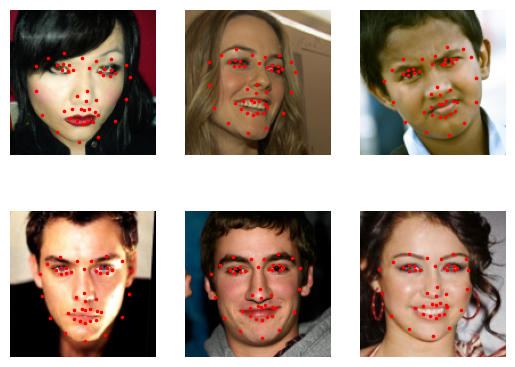

In [35]:
for i in range(min(test_images_norm.shape[0], 6)):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_images_norm[i])
    landmarks = predicted_landmarks[i]
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.axis('off')
plt.show()

In [36]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 34 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [37]:
save_as_csv(predicted_landmarks,"/content/drive/MyDrive/face alignment data")

#Error analysis for champian model

###mean and standard deviation of the Euclidean distance between the predicted landmarks and the ground truth landmarks on the full validation data

In [38]:
# Predict landmarks using the trained model
predicted_landmarks = final_model.predict(full_images_val)

# # Flatten the predicted and ground truth landmark arrays
predicted_landmarks_flat = predicted_landmarks.reshape(predicted_landmarks.shape[0], -1)
full_landmarks_flat = full_landmarks_val.reshape(full_landmarks_val.shape[0], -1)

# Compute the mean squared error between predicted and ground truth landmarks
mse = mean_squared_error(full_landmarks_flat, predicted_landmarks_flat)

# Compute the root mean squared error (RMSE) and standard deviation of the error
rmse = np.sqrt(mse)
std = np.std(predicted_landmarks_flat - full_landmarks_flat)

print("RMSE: {:.2f}".format(rmse))
print("Standard deviation of error: {:.2f}".format(std))

9/9 [==============================] - 0s 8ms/step
RMSE: 4.24
Standard deviation of error: 3.94


###model prediction on example images

In [39]:
predicted_exlandmarks = final_model.predict(ex_images_norm)

1/1 [==============================] - 0s 102ms/step


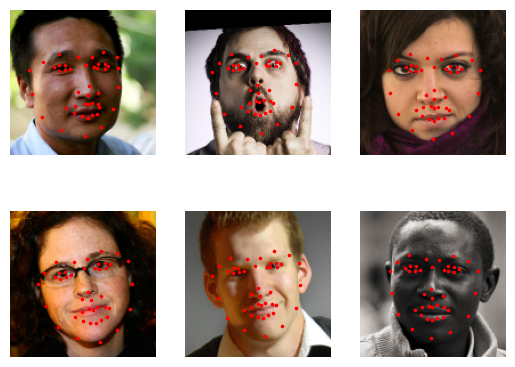

In [40]:
for i in range(min(ex_images_norm.shape[0], 6)):
    plt.subplot(2, 3, i+1)
    plt.imshow(ex_images_norm[i])
    landmarks = predicted_exlandmarks[i]
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.axis('off')
plt.show()